<a href="https://colab.research.google.com/github/sallypatteera/FYP_ctc_detection/blob/main/training/mobilenet_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Set up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Apr  9 08:21:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   44C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import cv2
import random

# 2. Prepare Data (can skip)

## Check invalid data

In [ ]:
invalid_path_base = "/content/drive/Shareddrives/FYP/Invalid crop"
A549_invalid_path = os.path.join(invalid_path_base, "A549")
HEYA8_invalid_path = os.path.join(invalid_path_base, "HEYA8")
T24_invalid_path = os.path.join(invalid_path_base, "T24")
H2452_invalid_path = os.path.join(invalid_path_base, "H2452")

In [ ]:
# print total number of images in each class
print("🏋️‍♀️🏋️‍♀️🏋️‍♀️🏋️‍♀️🏋️‍♀️")
print(f"total invalid A549 images: {len(os.listdir(A549_invalid_path))} images")
print(f"total invalid HEYA8 labels: {len(os.listdir(HEYA8_invalid_path))} images")
print(f"total invalid T24 images: {len(os.listdir(T24_invalid_path))} images")
print(f"total invalid H2452 labels: {len(os.listdir(H2452_invalid_path))} images")

🏋️‍♀️🏋️‍♀️🏋️‍♀️🏋️‍♀️🏋️‍♀️
total invalid A549 images: 849 images
total invalid HEYA8 labels: 850 images
total invalid T24 images: 850 images
total invalid H2452 labels: 814 images


In [ ]:
A549_invalid_img = [A549 for A549 in os.listdir(A549_invalid_path) if A549.endswith(('.jpg', '.png', '.jpeg'))]
HEYA8_invalid_img = [HEYA8 for HEYA8 in os.listdir(HEYA8_invalid_path) if HEYA8.endswith(('.jpg', '.png', '.jpeg'))]
T24_invalid_img = [T24 for T24 in os.listdir(T24_invalid_path) if T24.endswith(('.jpg', '.png', '.jpeg'))]
H2452_invalid_img = [H2452 for H2452 in os.listdir(H2452_invalid_path) if H2452.endswith(('.jpg', '.png', '.jpeg'))]

# Shuffle each list before selecting 150 images
random.shuffle(A549_invalid_img)
random.shuffle(HEYA8_invalid_img)
random.shuffle(T24_invalid_img)
random.shuffle(H2452_invalid_img)

# get only 150 images each
A549_invalid_img = A549_invalid_img[:150]
HEYA8_invalid_img = HEYA8_invalid_img[:150]
T24_invalid_img = T24_invalid_img[:150]
H2452_invalid_img = H2452_invalid_img[:150]

## Check valid data

In [ ]:
valid_path_base = "/content/drive/MyDrive/single_cell_data/train"
A549_valid_path = os.path.join(valid_path_base, "A549")
HEYA8_valid_path = os.path.join(valid_path_base, "HEYA8")
T24_valid_path = os.path.join(valid_path_base, "T24")
H2452_valid_path = os.path.join(valid_path_base, "H2452")

In [ ]:
# print total number of images in each class
print("🏋️‍♀️🏋️‍♀️🏋️‍♀️🏋️‍♀️🏋️‍♀️")
print(f"total valid A549 images: {len(os.listdir(A549_valid_path))} images")
print(f"total valid HEYA8 labels: {len(os.listdir(HEYA8_valid_path))} images")
print(f"total valid T24 images: {len(os.listdir(T24_valid_path))} images")
print(f"total valid H2452 labels: {len(os.listdir(H2452_valid_path))} images")

🏋️‍♀️🏋️‍♀️🏋️‍♀️🏋️‍♀️🏋️‍♀️
total valid A549 images: 748 images
total valid HEYA8 labels: 447 images
total valid T24 images: 935 images
total valid H2452 labels: 748 images


In [ ]:
A549_valid_img = [A549 for A549 in os.listdir(A549_valid_path) if A549.endswith(('.jpg', '.png', '.jpeg'))]
HEYA8_valid_img = [HEYA8 for HEYA8 in os.listdir(HEYA8_valid_path) if HEYA8.endswith(('.jpg', '.png', '.jpeg'))]
T24_valid_img = [T24 for T24 in os.listdir(T24_valid_path) if T24.endswith(('.jpg', '.png', '.jpeg'))]
H2452_valid_img = [H2452 for H2452 in os.listdir(H2452_valid_path) if H2452.endswith(('.jpg', '.png', '.jpeg'))]

# Shuffle each list before selecting 150 images
random.shuffle(A549_valid_img)
random.shuffle(HEYA8_valid_img)
random.shuffle(T24_valid_img)
random.shuffle(H2452_valid_img)

# get only 150 images each
A549_valid_img = A549_valid_img[:150]
HEYA8_valid_img = HEYA8_valid_img[:150]
T24_valid_img = T24_valid_img[:150]
H2452_valid_img = H2452_valid_img[:150]

In [ ]:
print(A549_valid_img[0])

tile_x005_y002_jpg.rf.1a70931a5a3563b9452733b45e5e53cf_14.jpg


## two folders: valid & invalid -> 150 images from each cell line to each folder

In [ ]:
# create directories
base = "/content/drive/MyDrive/filtering_data_v2"

invalid_dst = os.path.join(base, "invalid")
valid_dst = os.path.join(base, "valid")

os.makedirs(invalid_dst, exist_ok=True)
os.makedirs(valid_dst, exist_ok=True)

In [ ]:
# Function to copy images
def move_images(img_list, src_folder, dst_folder):
    for img in img_list:
        src = os.path.join(src_folder, img)
        dst = os.path.join(dst_folder, img)
        shutil.copy(src, dst)

In [ ]:
# Move the images
move_images(A549_invalid_img, A549_invalid_path, invalid_dst)
move_images(HEYA8_invalid_img, HEYA8_invalid_path, invalid_dst)
move_images(T24_invalid_img, T24_invalid_path, invalid_dst)
move_images(H2452_invalid_img, H2452_invalid_path, invalid_dst)

move_images(A549_valid_img, A549_valid_path, valid_dst)
move_images(HEYA8_valid_img, HEYA8_valid_path, valid_dst)
move_images(T24_valid_img, T24_valid_path, valid_dst)
move_images(H2452_valid_img, H2452_valid_path, valid_dst)

# 3. Load Data

## Visualize valid and invalid images

In [ ]:
base = "/content/drive/MyDrive/filtering"


invalid_dst = os.path.join(base, "invalid")
valid_dst = os.path.join(base, "valid")

print(f"total invalid images: {len(os.listdir(invalid_dst))}")
print(f"total valid images: {len(os.listdir(valid_dst))}")

total invalid images: 402
total valid images: 417


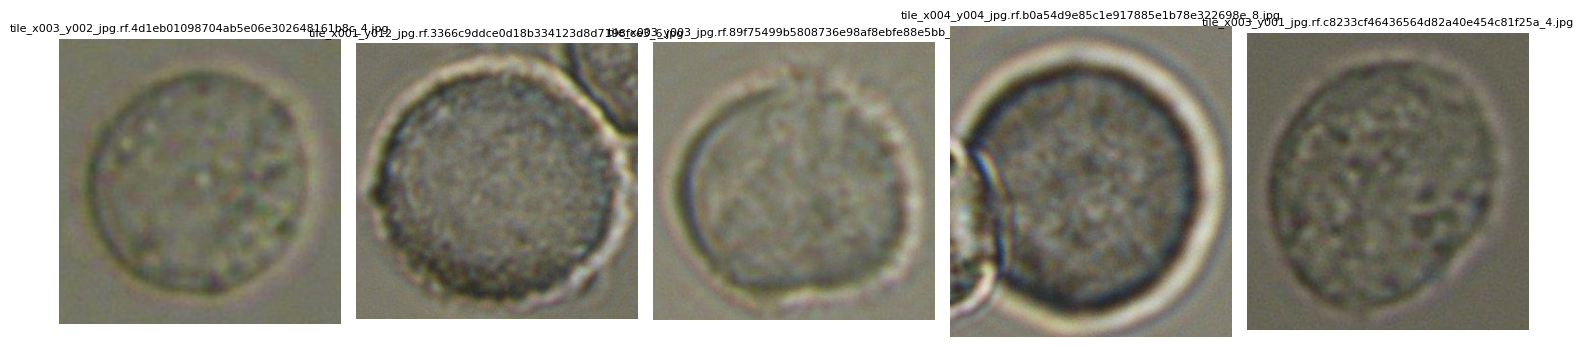

In [ ]:
# Get and shuffle image list
sample_valid_img = os.listdir(valid_dst)
random.shuffle(sample_valid_img)
sample_valid_img = sample_valid_img[:5]

# Plot 5 shuffled valid images
plt.figure(figsize=(15, 5))
for i, img_name in enumerate(sample_valid_img):
    img_path = os.path.join(valid_dst, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Move color conversion here
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(img_name, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


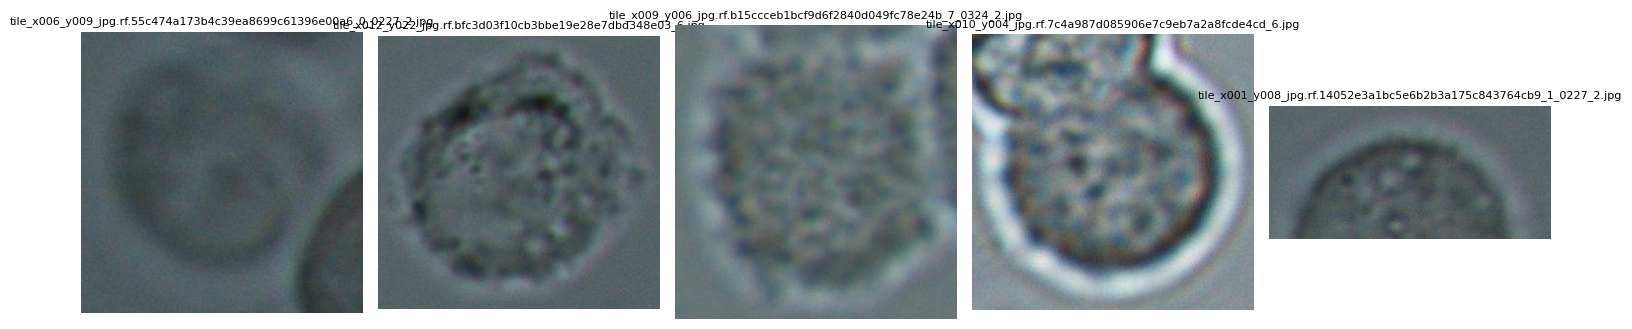

In [ ]:
# print sample invalid images
sample_invalid_img = os.listdir(invalid_dst)
random.shuffle(sample_invalid_img)
sample_invalid_img = sample_invalid_img[:5]

plt.figure(figsize=(15,5))
for i, img_name in enumerate(sample_invalid_img):
  img_path = os.path.join(invalid_dst, img_name)
  img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
  plt.subplot(1, 5, i+1)
  plt.imshow(img)
  plt.title(img_name, fontsize=8)
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2)

train_gen = datagen.flow_from_directory(
    base,  # Path to the dataset
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary',  # binary classification (valid or invalid)
    subset='training'
)

val_gen = datagen.flow_from_directory(
    base,  # Path to the dataset
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary',  # binary classification (valid or invalid)
    subset='validation'
)


Found 656 images belonging to 2 classes.
Found 163 images belonging to 2 classes.


In [ ]:
print(train_gen.class_indices)
# print(train_gen.classes)

{'invalid': 0, 'valid': 1}


# 4. Load MobileNet

In [ ]:
INPUT_SHAPE = (224, 224, 3)
def create_mobilenetv2_model(input_shape=INPUT_SHAPE):
    # Load MobileNetV2 pre-trained on ImageNet
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base layers

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification (valid vs invalid)
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
model = create_mobilenetv2_model()
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 5. Train the model

In [ ]:
# Plot training & validation accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training vs. Validation Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training vs. Validation Loss')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

In [ ]:
# Make sure the directory exists
os.makedirs("models", exist_ok=True)

# Set up checkpoint to save best model
checkpoint = ModelCheckpoint(
    filepath="models/mobilenetv2_filter_best_0904.h5",  # filename to save
    monitor='val_accuracy',                       # what to monitor
    save_best_only=True,                          # only save best version
    save_weights_only=False,                      # save full model
    verbose=1                                     # print save message
)

In [ ]:
filter_model = create_mobilenetv2_model(input_shape=(img_size, img_size, 3))

history = filter_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,  # Adjust epochs as needed
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.7864 - loss: 0.3837
Epoch 1: val_accuracy improved from -inf to 0.95092, saving model to models/mobilenetv2_filter_best_0904.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7913 - loss: 0.3771 - val_accuracy: 0.9509 - val_loss: 0.1299
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9373 - loss: 0.1652
Epoch 2: val_accuracy improved from 0.95092 to 0.97546, saving model to models/mobilenetv2_filter_best_0904.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 474ms/step - accuracy: 0.9383 - loss: 0.1628 - val_accuracy: 0.9755 - val_loss: 0.1062
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9621 - loss: 0.0979
Epoch 3: val_accuracy did not improve from 0.97546
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 463ms/step - accuracy: 0.9622 - loss: 0.0977 - val_accuracy: 0.9632 - val_loss: 0.1082
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9735 - loss: 0.0789
Epoch 4: val_accuracy did not improve from 0.97546
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 464ms/step - accuracy: 0.9734 - loss: 0.0792 - val_accuracy: 0.9693 - val_loss: 0.0964
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.9619 - loss: 0.0909
Epoch 5: val_accuracy improved from 0.97546 to 0.98160, saving model to models/mobilenetv2_filter_best_0904.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 489ms/step - accuracy: 0.9623 - loss: 0.0904 - val_accuracy: 0.9816 - val_loss: 0.0729
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9752 - loss: 0.0524
Epoch 6: val_accuracy did not improve from 0.98160
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 460ms/step - accuracy: 0.9754 - loss: 0.0529 - val_accuracy: 0.9816 - val_loss: 0.0666
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9782 - loss: 0.0537
Epoch 7: val_accuracy did not improve from 0.98160
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 464ms/step - accuracy: 0.9782 - loss: 0.0538 - val_accuracy: 0.9693 - val_loss: 0.0863
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9865 - loss: 0.0557
Epoch 8: val_accuracy did not improve from 0.98160
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 458ms/step - accuracy: 0.9866 - loss: 0.0553 - val_accuracy: 0.9693 - val_loss: 0.0859
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9883 - loss: 0.0421
Epoch 9: val_accuracy did not i

21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 483ms/step - accuracy: 0.9863 - loss: 0.0367 - val_accuracy: 0.9877 - val_loss: 0.0495
Epoch 13/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9956 - loss: 0.0308
Epoch 13: val_accuracy did not improve from 0.98773
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 466ms/step - accuracy: 0.9954 - loss: 0.0309 - val_accuracy: 0.9693 - val_loss: 0.1062
Epoch 14/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.9920 - loss: 0.0294
Epoch 14: val_accuracy improved from 0.98773 to 0.99387, saving model to models/mobilenetv2_filter_best_0904.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 472ms/step - accuracy: 0.9919 - loss: 0.0297 - val_accuracy: 0.9939 - val_loss: 0.0366
Epoch 15/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9895 - loss: 0.0336
Epoch 15: val_accuracy did not improve from 0.99387
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 464ms/step - accuracy: 0.9897 - loss: 0.0334 - val_accuracy: 0.9632 - val_loss: 0.0839
Epoch 16/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9904 - loss: 0.0262
Epoch 16: val_accuracy did not improve from 0.99387
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 466ms/step - accuracy: 0.9907 - loss: 0.0260 - val_accuracy: 0.9693 - val_loss: 0.0886
Epoch 17/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9901 - loss: 0.0211
Epoch 17: val_accuracy did not improve from 0.99387
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 465ms/step - accuracy: 0.9902 - loss: 0.0212 - val_accuracy: 0.9755 - val_loss: 0.0788
Epoch 18/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9884 - loss: 0.0336
Epoch 18: val_accuracy d

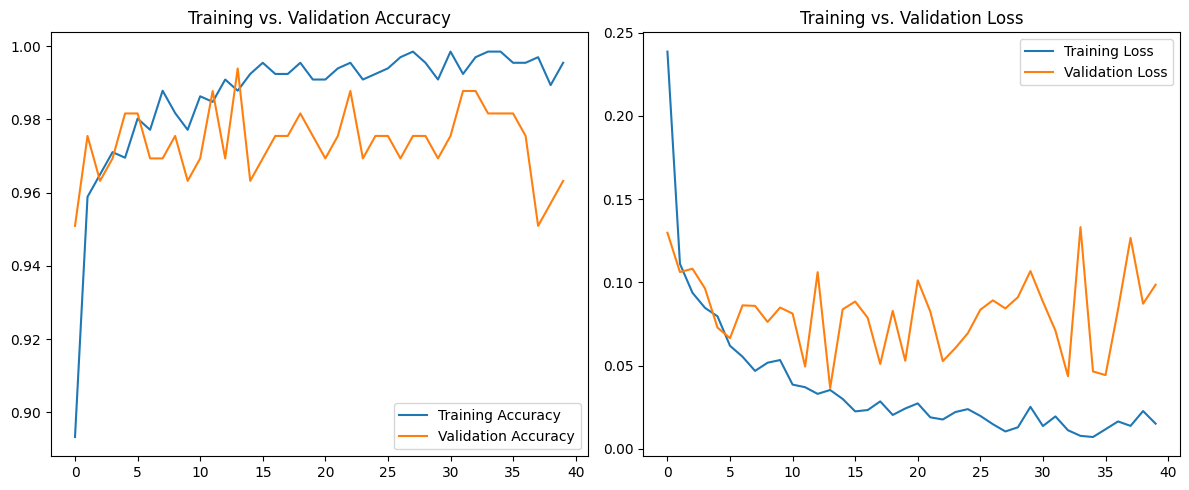

In [ ]:
plot_training_history(history)

In [ ]:
# # Save the entire model (architecture + weights + optimizer state)
# filter_model.save("models/mobilenetv2_filter_model.h5")
from google.colab import files
files.download("models/mobilenetv2_filter_best_0904.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_loss, test_acc = filter_model.evaluate(val_gen)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - accuracy: 0.9641 - loss: 0.0995
Test accuracy: 0.9693251252174377
Test loss: 0.08023993670940399


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step
              precision    recall  f1-score   support

           0       0.52      0.51      0.52        80
           1       0.54      0.54      0.54        83

    accuracy                           0.53       163
   macro avg       0.53      0.53      0.53       163
weighted avg       0.53      0.53      0.53       163



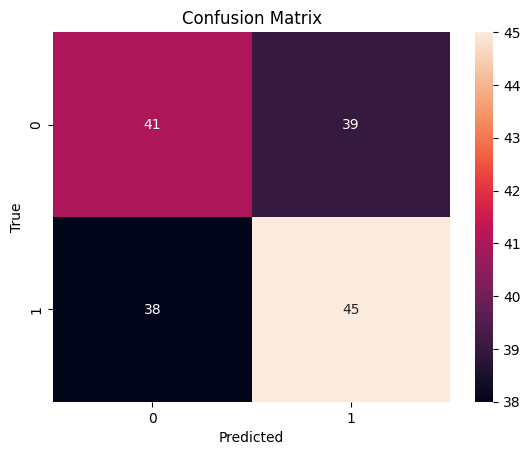

In [ ]:
# metrics
val_preds = filter_model.predict(val_gen)
y_pred = (val_preds > 0.3).astype("int32").flatten()
y_true = val_gen.classes[:len(y_pred)]

print(classification_report(y_true, y_pred))

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.png')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 707ms/step
              precision    recall  f1-score   support

           0       0.55      0.48      0.51       120
           1       0.54      0.60      0.57       120

    accuracy                           0.54       240
   macro avg       0.54      0.54      0.54       240
weighted avg       0.54      0.54      0.54       240



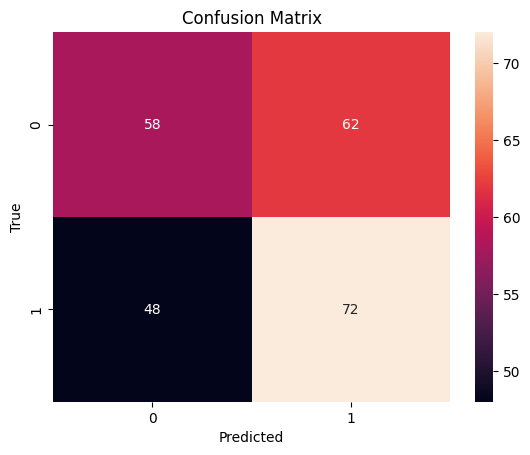

In [ ]:
# metrics
val_preds = filter_model.predict(val_gen)
y_pred = (val_preds > 0.5).astype("int32").flatten()
y_true = val_gen.classes[:len(y_pred)]

print(classification_report(y_true, y_pred))

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.png')
plt.show()

# 6. Prediction

In [ ]:
import cv2
import os

folder = "/content/test"
new_crop_list = []
for image in os.listdir(folder):
    img = cv2.imread(os.path.join(folder, image))
    if img is not None:
        new_crop_list.append(img)

In [ ]:
# Test a batch of new crops
# Preprocess a single cell crop (resize, normalize)
def preprocess_crop_filter(crop):
    img = tf.image.resize(crop, (224, 224))  # change to your training size
    img = tf.cast(img, tf.float32) / 255.0
    return img

preds = filter_model.predict(tf.stack([preprocess_crop_filter(crop) for crop in new_crop_list]))

# Filter by confidence
valid_crops = [crop for crop, p in zip(new_crop_list, preds) if p > 0.]
print(f"{len(valid_crops)} valid crops out of {len(new_crop_list)}.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4 valid crops out of 18.
